## Feature analysis
---
This notebook studies the feature maps learned by octave UNet and baseline UNet.

In [1]:
# setup path environment
import os
import sys

project_dir, _ = os.path.split(os.getcwd())
if project_dir not in sys.path:
    sys.path.append(project_dir)

# import packages for data manipulation and drawing
import pandas as pd
import numpy as np
import scipy as sp

# for ploting inline on the notebook
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper', font_scale=1.5)

from PIL import Image
import torch
from torch.nn import functional as F
from torchvision.transforms import functional as TF


## Prepare data samples
---
We first by loading the testing samples of the DRIVE datasets.

You can checkout [this notebook](./retinal-vessel-segmentation-datasets.ipynb) for details of how to use the dataset classes for retinal vessel segmentation.


In [2]:
from src.datasets.drive_dataset import DRIVEDataset
from src.processings.preprocessings import resize

drive_valid_set = DRIVEDataset(data_root='../data', split_mode='valid', 
                               preprocessing=resize, augmentation=None)

from torch.utils.data import DataLoader, Subset

drive_valid_loader = DataLoader(drive_valid_set, batch_size=len(drive_valid_set))
sample_idx = 2

# drive_valid_loader = DataLoader(Subset(drive_valid_set, indices=(2, )), batch_size=1)
# sample_idx = 0

drive_valid_samples = next(iter(drive_valid_loader))


## Prepare models
---
Then we create and load the pre-trained octave UNet and baseline UNet model.

In [3]:
exp_dirs = ['../exps/ablation-study/alpha_0.5', 
            '../exps/ablation-study/alpha_0.0']
exp_names = ['Octave UNet (α=0.5)', 
             'UNet (α=0)']

from src.configs.config_node import ConfigNode
def get_configs_from_file(configs_file_path):
    """Read config file."""
    configs = ConfigNode(new_allowed=True)
    configs.merge_from_file(configs_file_path)
    return configs

def get_clean_ckpt(exp_ckpt):
    """Remove nonessential keys from checkpoint."""
    valid_keys = ('weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked')
    for key in list(exp_ckpt['model'].keys()):
        if key.split('.')[-1] not in valid_keys:
            del exp_ckpt['model'][key]
    return exp_ckpt

from src.agents.retina.utils.get_model import get_model
def get_model_from_exp_dir(exp_dir, monitor='last', ckpts_dir='ckpts', strict_load=True):
    """Load a pre-trained model"""
    configs_file_path = os.path.join(exp_dir, 'run_time_configs.yaml')
    configs = get_configs_from_file(configs_file_path)
    model = get_model(configs)
    exp_ckpt_path = os.path.join(exp_dir, ckpts_dir, monitor + '.pth')
    exp_ckpt = torch.load(exp_ckpt_path)
    exp_ckpt = get_clean_ckpt(exp_ckpt)
    model.load_state_dict(exp_ckpt['model'], strict=strict_load)
    return model

octave_unet = get_model_from_exp_dir(exp_dirs[0])
unet = get_model_from_exp_dir(exp_dirs[1])


## Retrieve feature maps
---
Obtain kernel response while runing data samples through the models.

In [4]:
from collections import OrderedDict
def get_activations(model, inputs):
    """Retrieve feature maps."""
    activations = OrderedDict()
    def get_module_activations(module_name):
        def hook(model, inputs, outputs):
            module_activations = []
            if isinstance(outputs, tuple):
                for output in outputs:
                    if output is not None:
                        module_activations.append(output.detach())
                    else:
                        module_activations.append(output)
            else:
                assert isinstance(outputs, torch.Tensor)
                if outputs is not None:
                    module_activations.append(outputs.detach())
                else:
                    module_activations.append(outputs)     
            activations[module_name] = module_activations
        return hook
    input_channels, *layer_channels, output_channels = model.channels
    if len(layer_channels) >= 0:
        model.encoder_0.register_forward_hook(get_module_activations('encoder_0'))
        model.decoder_0.register_forward_hook(get_module_activations('decoder_0'))
    if len(layer_channels) >= 1:
        model.encoder_1.register_forward_hook(get_module_activations('encoder_1'))
        model.decoder_1.register_forward_hook(get_module_activations('decoder_1'))
    if len(layer_channels) >= 2:
        model.encoder_2.register_forward_hook(get_module_activations('encoder_2'))
        model.decoder_2.register_forward_hook(get_module_activations('decoder_2'))
    if len(layer_channels) >= 3:
        model.encoder_3.register_forward_hook(get_module_activations('encoder_3'))
        model.decoder_3.register_forward_hook(get_module_activations('decoder_3'))
    if len(layer_channels) >= 4:
        model.encoder_4.register_forward_hook(get_module_activations('encoder_4'))
        model.decoder_4.register_forward_hook(get_module_activations('decoder_4'))
    model.eval()
    outputs = model(inputs)
    return activations

octave_unet_feature_maps = get_activations(octave_unet, drive_valid_samples['image'])
unet_feature_maps = get_activations(unet, drive_valid_samples['image'])


### Visualizing the feature maps
---
Once the feature maps are retrieved, you can use the following keys to access the feature maps of a module. 

In [5]:
octave_unet_feature_maps.keys()

odict_keys(['encoder_0', 'encoder_1', 'encoder_2', 'encoder_3', 'encoder_4', 'decoder_4', 'decoder_3', 'decoder_2', 'decoder_1', 'decoder_0'])

In [38]:
def plot_map(data, save_name=None, logarithmic=False, 
             figsize=(7.5, 7.5), cmap='gray',
             show_ticks=True, show_colorbar=False):
    """Plot an 2D array with ticks showing shape."""
    if logarithmic:
        data = torch.log(data)
    h, w = data.shape
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    g = axis.imshow(data, cmap=cmap)
    if show_ticks:
        axis.xaxis.tick_top()
        axis.yaxis.tick_left()
        axis.set_xticks(np.arange(0, w+1, w/2))
        axis.set_yticks(np.arange(0, h+1, h/2))
    else:
        axis.set_xticks([])
        axis.set_yticks([])
    axis.xaxis.set_tick_params(width=3, length=10, labelsize=35)
    axis.yaxis.set_tick_params(width=3, length=10, labelsize=35)
    axis.grid(None)
    fig.tight_layout()
    if show_colorbar:
        fig.colorbar(g)
    if save_name is not None:
        plt.savefig(save_name + '.pdf')
    
    plt.show()
    

Instead of looping over each channels of activations, we visualize the averaged version of a module.

Here is how features of the high- and low- frequency groups from octave UNet looks like. 

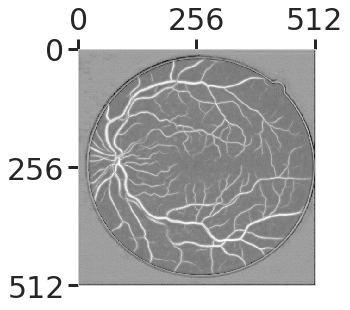

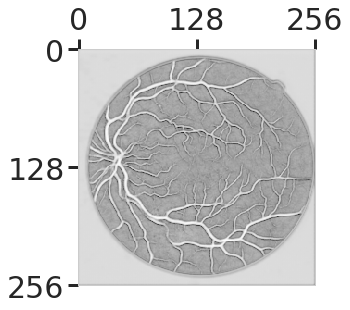

In [7]:
plot_map(octave_unet_feature_maps['decoder_1'][0][sample_idx, :, :, :].mean(0), logarithmic=True, figsize=(5, 5))
plot_map(octave_unet_feature_maps['decoder_1'][1][sample_idx, :, :, :].mean(0), logarithmic=True, figsize=(5, 5))


And the ones of baseline UNet model.

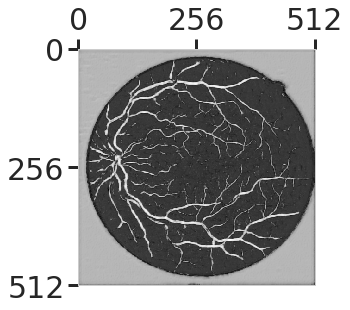

In [8]:
plot_map(unet_feature_maps['decoder_1'][0][sample_idx, :, :, :].mean(0), logarithmic=True, figsize=(5, 5))


You can also access `decode_0` for the final outputed probability maps of each model, from which you can see that the segmentation result from octave UNet is more sensitive to thin vessels and is with less fragments than the output of the baseline.  

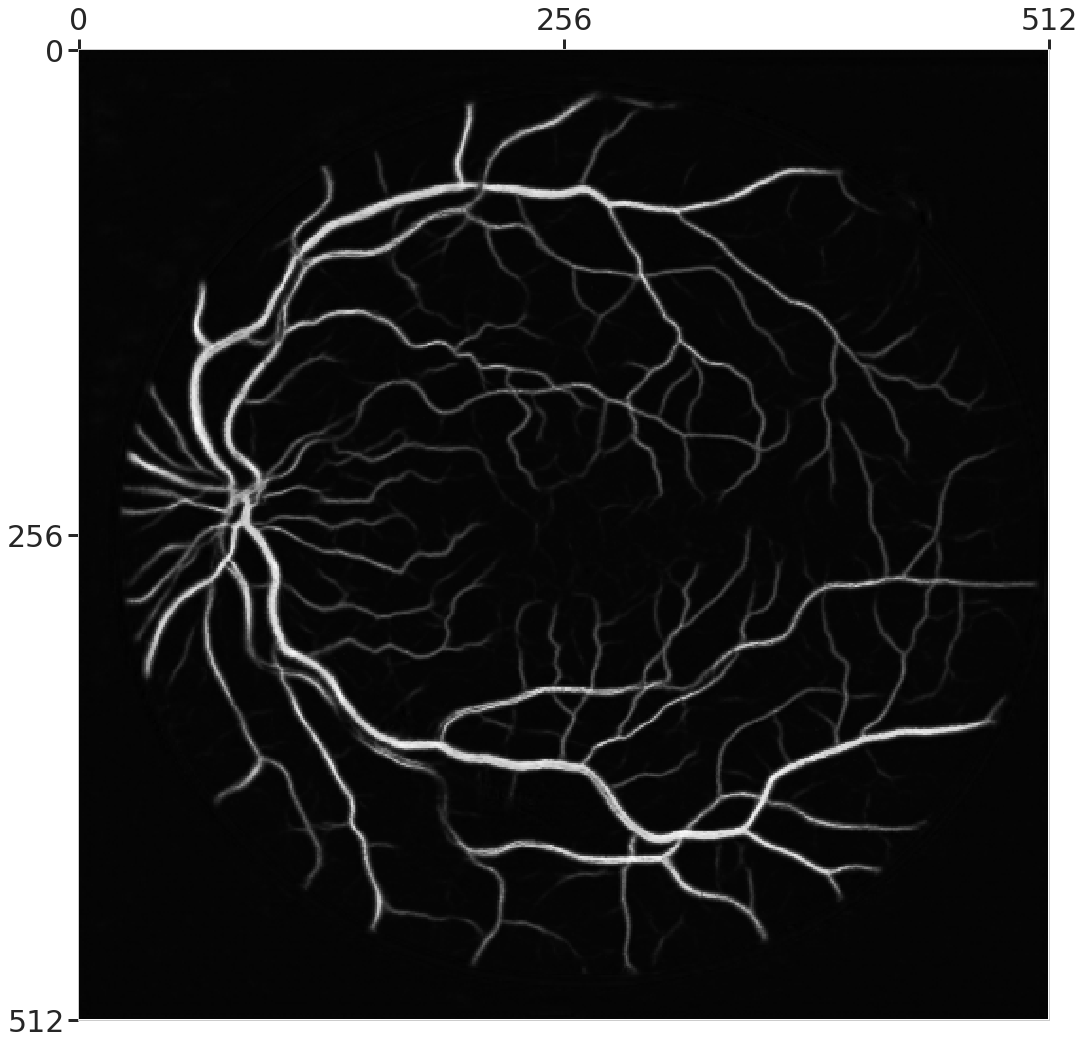

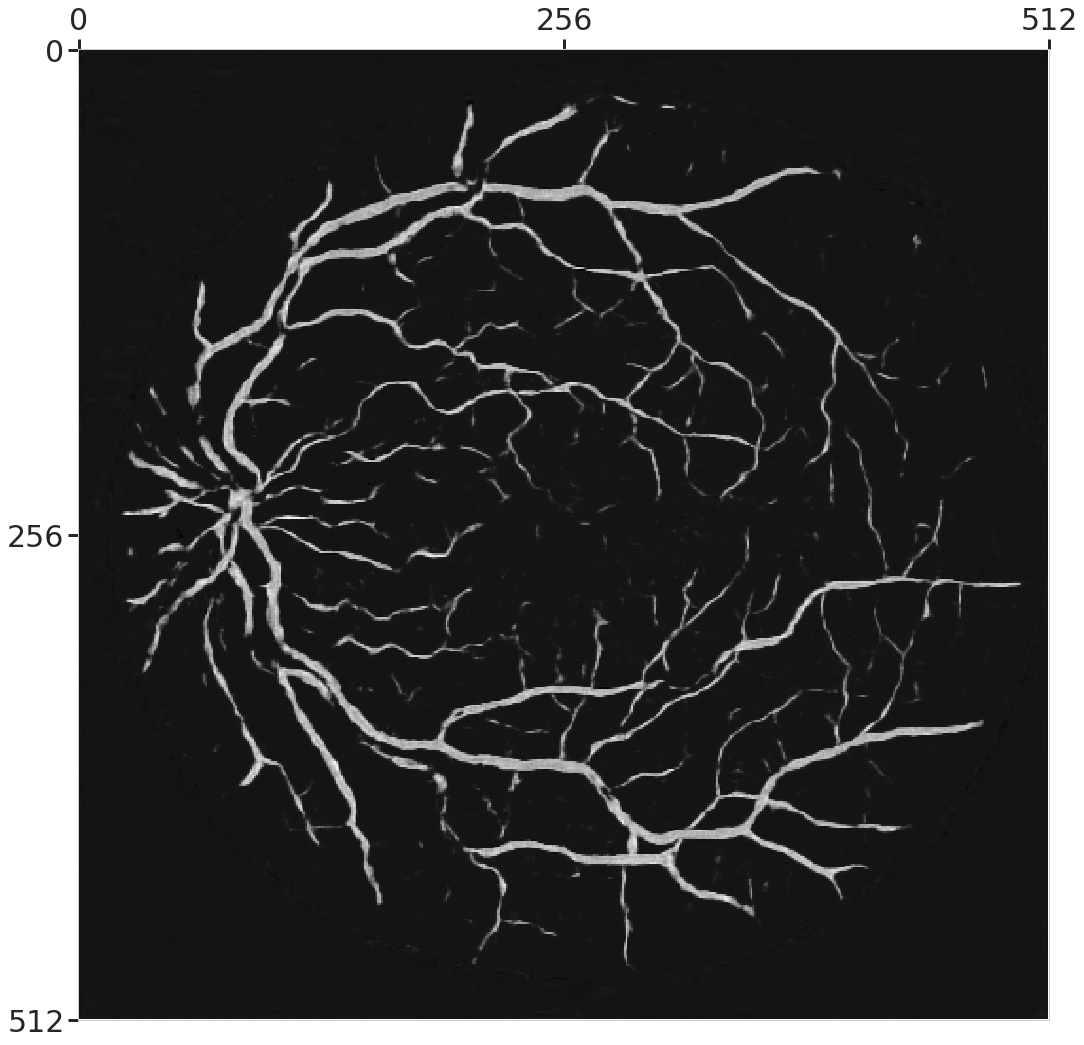

In [9]:
plot_map(octave_unet_feature_maps['decoder_0'][0][sample_idx, :, :, :].squeeze(), logarithmic=False, figsize=(15, 15))
plot_map(unet_feature_maps['decoder_0'][0][sample_idx, :, :, :].squeeze(), logarithmic=False, figsize=(15, 15))


Uncomment the following block to write out the averaged feature maps of all modules.


In [49]:
# try:
#     os.mkdir('feature-maps')
# except:
#     pass

# try:
#     os.mkdir('feature-maps/octave-unet')
# except:
#     pass

# plot_map(octave_unet_feature_maps['encoder_0'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_0-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_0'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_0-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_1'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_1-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_1'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_1-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_2'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_2-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_2'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_2-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_3'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_3-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_3'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_3-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_4'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_4-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['encoder_4'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/encoder_4-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_3'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_3-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_3'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_3-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_2'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_2-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_2'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_2-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_1'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_1-high', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_1'][1][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_1-low', logarithmic=True)
# plot_map(octave_unet_feature_maps['decoder_0'][0][sample_idx, :, :, :].mean(0), 'feature-maps/octave-unet/decoder_0-high', logarithmic=False)

# try:
#     os.mkdir('feature-maps/unet')
# except:
#     pass

# plot_map(unet_feature_maps['encoder_0'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/encoder_0', logarithmic=True)
# plot_map(unet_feature_maps['encoder_1'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/encoder_1', logarithmic=True)
# plot_map(unet_feature_maps['encoder_2'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/encoder_2', logarithmic=True)
# plot_map(unet_feature_maps['encoder_3'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/encoder_3', logarithmic=True)
# plot_map(unet_feature_maps['encoder_4'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/encoder_4', logarithmic=True)
# plot_map(unet_feature_maps['decoder_3'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/decoder_3', logarithmic=True)
# plot_map(unet_feature_maps['decoder_2'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/decoder_2', logarithmic=True)
# plot_map(unet_feature_maps['decoder_1'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/decoder_1', logarithmic=True)
# plot_map(unet_feature_maps['decoder_0'][0][sample_idx, :, :, :].mean(0), 'feature-maps/unet/decoder_0', logarithmic=False)


## Frequency analysis of the feature maps
---
We can apply the [discrete fourier transformation](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) on images to analys what spatial frequency component an image contains.

Similar approach is applied on the feature maps of neural networks here. We will first apply real-to-complex FFT on feature maps to obtain the coresponding frequency and phase component of FFT response (energy), then shift the low frequency components to the center of the response map and high frequency components to the edges for better visualization. 

In [11]:
def fftshift(freq, axes):
    shifts = [freq.shape[axis] // 2 for axis in axes]        
    return torch.roll(freq, shifts, axes)

ifftshift = fftshift

def get_frequency(activations, shifted=True, normalized=False, onesided=False):
    activations_fft = OrderedDict()
    for module_name, module_activations in activations.items():
        module_activations_fft = []
        for module_activation in module_activations:
            if module_activation is not None:
                module_activation_fft = torch.rfft(module_activation, signal_ndim=2, 
                                                   normalized=normalized, onesided=onesided)
                if shifted:
                    module_activation_fft = fftshift(module_activation_fft, axes=(-3, -2))
                b, c, h, w, d = module_activation_fft.shape
                module_activations_fft.append(module_activation_fft)
            else:                
                module_activations_fft.append(None)
        activations_fft[module_name] = module_activations_fft
    return activations_fft

octave_unet_frequency_maps = get_frequency(octave_unet_feature_maps)
unet_frequency_maps = get_frequency(unet_feature_maps)


Similary, instead of showing each frequency maps one by one, we calculate the averaged feature maps extracted from all modules of a model.

In [12]:
def get_mean_frequency_maps(feature_maps, module_names=None, sample_index=None,
                            resolution=(512, 512), logarithmic=True):
    mean_feature_high = torch.zeros(resolution)
    mean_feature_low = torch.zeros(resolution)
    high_count = 0
    low_count = 0
    for name, module_feature_maps in feature_maps.items():
        if (module_names is None) or (module_names is not None and name in module_names):
            for idx, module_feature_map in enumerate(module_feature_maps):
                if module_feature_map is not None and idx == 1:
                    b, c, h, w, d = module_feature_map.shape
                    if sample_index is not None:
                        mean_feature_low += F.interpolate(amodule_feature_map[sample_index:, :, :, :, 0], size=resolution).mean((0, 1))
                    else:
                        mean_feature_low += F.interpolate(module_feature_map[:, :, :, :, 0], size=resolution).mean((0, 1))
                    low_count += 1
                elif module_feature_map is not None and idx == 0:
                    b, c, h, w, d = module_feature_map.shape
                    if sample_index is not None:
                        mean_feature_high += F.interpolate(module_feature_map[sample_index:, :, :, :, 0], size=resolution).mean((0, 1))    
                    else:
                        mean_feature_high += F.interpolate(module_feature_map[:, :, :, :, 0], size=resolution).mean((0, 1))
                    high_count += 1
    if low_count != 0:
        mean_feature_low = mean_feature_low / low_count
        mean_feature_high = mean_feature_high / high_count
    elif low_count == 0:
        mean_feature_high = mean_feature_high / (2 * high_count)
    if logarithmic:
        mean_feature_high = torch.log(torch.abs(mean_feature_high) + 1e-6)
        mean_feature_low = torch.log(torch.abs(mean_feature_low) + 1e-6)
    if low_count == 0:
        mean_feature_low = None
    return mean_feature_high, mean_feature_low

octave_unet_mean_frequency_maps_high, octave_unet_mean_frequency_maps_low = get_mean_frequency_maps(octave_unet_frequency_maps)
unet_mean_frequency_maps_high, _ = get_mean_frequency_maps(unet_frequency_maps)


### Visualize frequency of features
---
The following shows the FFT response of feature maps of octave UNet, which demonstrated the different characteristics between the high frequency group and the low frequenct group of features.

The first image depict the FFT response from the high frequency group, which contains both low and high frequency components, and the energy is relatively more spread out around the center (i.e, the shifted frequency of 0).

One the other hand, the 2nd image that shows the FFT response of the low frequency group is more focused around the 0 frequency, and has less high frequency components.

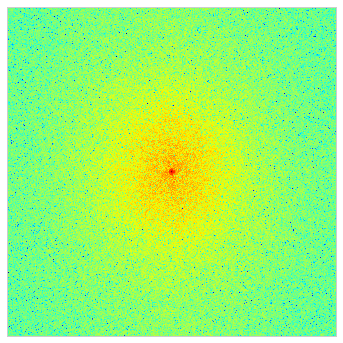

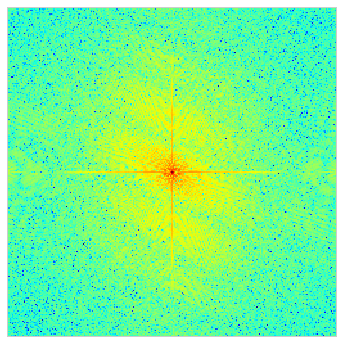

In [13]:
plot_map(octave_unet_mean_frequency_maps_high, cmap='jet', figsize=(5, 5), show_ticks=False)
plot_map(octave_unet_mean_frequency_maps_low, cmap='jet', figsize=(5, 5), show_ticks=False)


Similarly, the following image shows the FFT response of the features of the baseline UNet, which contains both low and high frequency components.

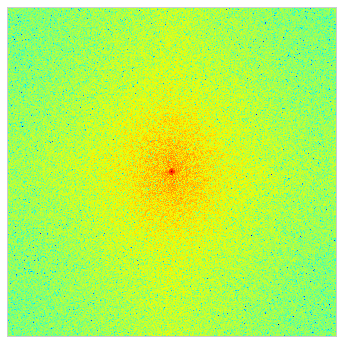

In [14]:
plot_map(unet_mean_frequency_maps_high, cmap='jet', figsize=(5, 5), show_ticks=False)


Uncomment the following block to write out the averaged frequency maps of all modules.

In [27]:
# try:
#     os.mkdir('frequency-maps')
# except:
#     pass

# try:
#     os.mkdir('frequency-maps/octave-unet')
# except:
#     pass

# plot_map(octave_unet_mean_frequency_maps_high, 'frequency-maps/octave-unet/mean-high', logarithmic=False, cmap='jet', show_ticks=False)
# plot_map(octave_unet_mean_frequency_maps_low, 'frequency-maps/octave-unet/mean-low', logarithmic=False, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_0'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_0-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_0'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_0-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_1'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_1-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_1'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_1-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_2'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_2-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_2'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_2-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_3'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_3-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_3'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_3-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_4'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_4-high', logarithmic=False, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['encoder_4'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/encoder_4-low', logarithmic=False, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_3'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_3-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_3'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_3-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_2'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_2-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_2'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_2-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_1'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_1-high', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_1'][1][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_1-low', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(octave_unet_frequency_maps['decoder_0'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/octave-unet/decoder_0-high', logarithmic=True, cmap='jet', show_ticks=False)

# try:
#     os.mkdir('frequency-maps/unet')
# except:
#     pass

# plot_map(unet_mean_frequency_maps_high, 'frequency-maps/unet/mean', logarithmic=False, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['encoder_0'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/encoder_0', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['encoder_1'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/encoder_1', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['encoder_2'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/encoder_2', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['encoder_3'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/encoder_3', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['encoder_4'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/encoder_4', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['decoder_3'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/decoder_3', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['decoder_2'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/decoder_2', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['decoder_1'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/decoder_1', logarithmic=True, cmap='jet', show_ticks=False)
# plot_map(unet_frequency_maps['decoder_0'][0][sample_idx, :, :, :, 0].mean(0), 'frequency-maps/unet/decoder_1', logarithmic=True, cmap='jet', show_ticks=False)


## Flatten frequency maps by radii
---
Even given the heat map representation of the frequency maps, it's still quite hard to understand how are the features learned by octave UNet different from those of the baseline UNet model. 

To adress this issue, we decided to flatten out the FFT responses into 1D signal and try to compare them. Specifically, we indexed the pixels of the 2D frequency maps by their radii of a polar coordinate, of which the origin locals at the 0 frequency of frequency maps.

In [16]:
def flaten_by_radii(feature_map, axes=(-2, -1)):
    h_grid, w_grid = np.indices([feature_map.shape[dim] for dim in axes])
    center = ((h_grid.max() - h_grid.min()) / 2.0, (w_grid.max() - w_grid.min()) / 2.0)
    radii_grid = np.hypot(h_grid - center[0], w_grid - center[1])
    indices = np.argsort(radii_grid.flat)
    return feature_map.flatten()[indices]

def plot_spectrums(feature_maps, names, save_name=None,
                   smooth_factor=None, dash_idx=-1,
                   figsize=(15, 7.5), linewidth=3, font_scale=2):    
    sns.set(style='whitegrid', font_scale=font_scale)
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    
    for feature_map in feature_maps:
        feature_map = flaten_by_radii(feature_map)
        sampling_frequency = list(range(feature_map.numel()))
        if smooth_factor is not None:
            feature_map = np.poly1d(np.polyfit(sampling_frequency, feature_map.numpy(), smooth_factor))(sampling_frequency)
        g = sns.lineplot(x=sampling_frequency, y=feature_map,
                         linewidth=linewidth, ax=axis)
    if dash_idx is not None:
        axis.lines[dash_idx].set_linestyle('--')
    g.legend(names, loc='upper right')
    axis.set(xlabel='frequency', ylabel='energy')
    fig.tight_layout()
    if save_name is not None:
        plt.savefig(save_name + '.pdf')
    plt.show()
    sns.set(style='whitegrid')
    sns.set_context('paper', font_scale=1.5)
    

However, it's too long a 1D signal to plot, and we decided to:
- fit a polynomial to represente the 1D FFT signal, 
- and down sample the 1D FFT signal.

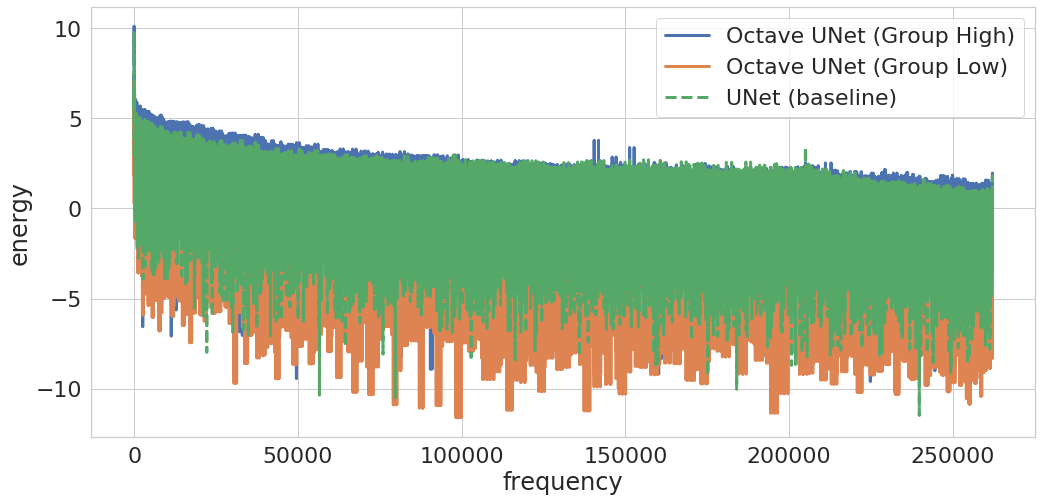

In [17]:
plot_spectrums((octave_unet_mean_frequency_maps_high, 
                octave_unet_mean_frequency_maps_low, 
                unet_mean_frequency_maps_high), 
               ('Octave UNet (Group High)', 
                'Octave UNet (Group Low)', 
                'UNet (baseline)'))


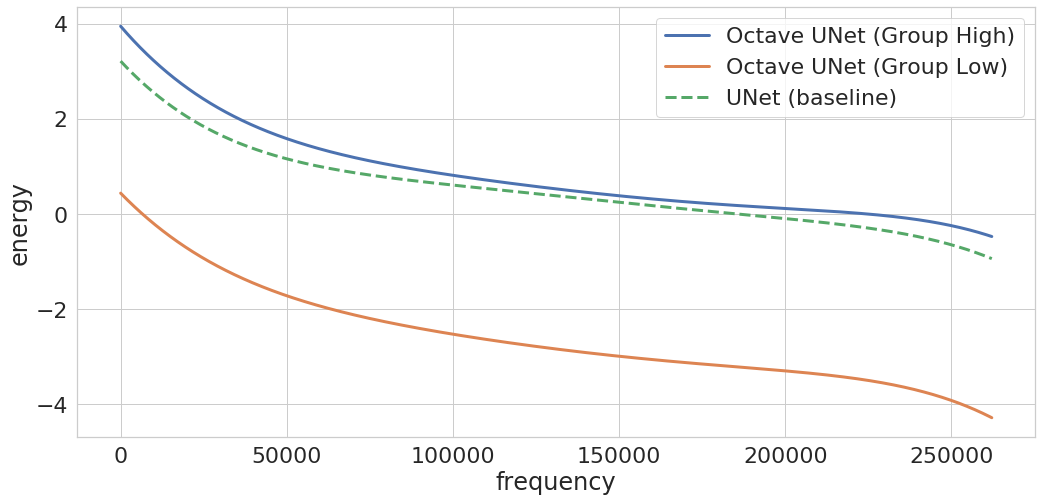

In [18]:
plot_spectrums((octave_unet_mean_frequency_maps_high, 
                octave_unet_mean_frequency_maps_low, 
                unet_mean_frequency_maps_high), 
               ('Octave UNet (Group High)', 
                'Octave UNet (Group Low)', 
                'UNet (baseline)'), smooth_factor=5)


In [47]:
def get_sampled_spectrum(data, axes):
    h_grid, w_grid = np.indices([data.shape[dim] for dim in axes])
    center = ((h_grid.max() - h_grid.min()) / 2.0, (w_grid.max() - w_grid.min()) / 2.0)
    radii_grid = np.hypot(h_grid - center[0], w_grid - center[1])
    
    indices = np.argsort(radii_grid.flat)
    radii_sorted = radii_grid.flat[indices].astype(int)
    
    radii_delta = radii_sorted[1:] - radii_sorted[:-1]
    radii_bins = radii_delta.nonzero()[0]
    radii_bins_delta = radii_bins[1:] - radii_bins[:-1]
    
    redundent_data_flat_shape = [dim if axis not in axes and axis - len(data.shape) not in axes else -1 for axis, dim in enumerate(data.shape)]
    data_flat_shape = [dim for axis, dim in enumerate(redundent_data_flat_shape) if dim != -1 or (dim == -1 and redundent_data_flat_shape[axis - 1] != -1)]
    indices_unsqueezed_shape = [dim if dim == -1 else 1 for dim in data_flat_shape]

    data_sorted = data.view(data_flat_shape).index_select(data_flat_shape.index(-1), torch.from_numpy(indices))
    cumulative_sum = torch.cumsum(data_sorted, dim=data_flat_shape.index(-1))
    cumulative_sum_bins = cumulative_sum.index_select(data_flat_shape.index(-1), torch.from_numpy(radii_bins[1:])) - cumulative_sum.index_select(data_flat_shape.index(-1), torch.from_numpy(radii_bins[:-1]))
    radii_spectrum = cumulative_sum_bins / torch.from_numpy(radii_bins_delta).view(indices_unsqueezed_shape)
    return radii_spectrum

def plot_sampled_spectrums(feature_maps, names, save_name=None,
                           smooth_factor=None, dash_idx=None,
                           figsize=(15, 7.5), linewidth=3, font_scale=2):    
    sns.set(style='whitegrid', font_scale=font_scale)
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    
    for feature_map in feature_maps:
        feature_map = get_sampled_spectrum(feature_map.unsqueeze(0), axes=(-2, -1)).squeeze()
        sampling_frequency = list(range(feature_map.numel()))
        if smooth_factor is not None:
            feature_map = np.poly1d(np.polyfit(sampling_frequency, feature_map.numpy(), smooth_factor))(sampling_frequency)
        g = sns.lineplot(x=sampling_frequency, y=feature_map,
                         linewidth=linewidth, ax=axis)
    if dash_idx is not None:
        axis.lines[dash_idx].set_linestyle('--')
    g.legend(names, loc='upper right')
    axis.set(xlabel='sampling frequency', ylabel='energy')
    fig.tight_layout()
    if save_name is not None:
        plt.savefig(save_name + '.pdf')
    plt.show()
    sns.set(style='whitegrid')
    sns.set_context('paper', font_scale=1.5)
    

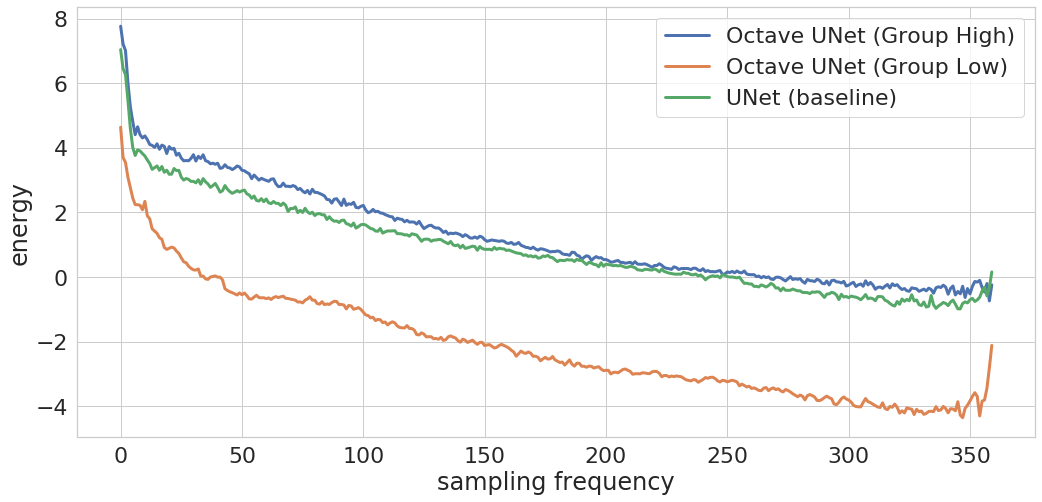

In [26]:
plot_sampled_spectrums((octave_unet_mean_frequency_maps_high, 
                        octave_unet_mean_frequency_maps_low, 
                        unet_mean_frequency_maps_high), 
                       ('Octave UNet (Group High)', 
                        'Octave UNet (Group Low)', 
                        'UNet (baseline)'))


From the above two energy figures, we can conclue that the multi-frequency learning approach of a octave UNet is different from a baseline UNet in a way that the low frequency group does focused on learning low frequency features while the high frequency group contains more high frequency components than those of the baseline model.

Combining the emprical results we show in [ablation study](./ablation-study.ipynb), one can argues that the multi-frequency learning approach of a octave UNet can be better suited for retinal vessel segmentation than a baseline model.

In [71]:
# try:
#     os.mkdir('spectrums')
# except:
#     pass

# plot_spectrums((octave_unet_mean_frequency_maps_high, 
#                 octave_unet_mean_frequency_maps_low, 
#                 unet_mean_frequency_maps_high), 
#                ('Octave UNet (high frequency features)', 
#                 'Octave UNet (low frequency features)', 
#                 'UNet (baseline)'),
#                'spectrums/flattened-FFT-spectrums')

# plot_spectrums((octave_unet_mean_frequency_maps_high, 
#                 octave_unet_mean_frequency_maps_low, 
#                 unet_mean_frequency_maps_high), 
#                ('Octave UNet (high frequency features)', 
#                 'Octave UNet (low frequency features)', 
#                 'UNet (baseline)'),
#                'spectrums/smoothed-FFT-spectrums', smooth_factor=5,
#                linewidth=4,
#                font_scale=2.5)

# plot_sampled_spectrums((octave_unet_mean_frequency_maps_high, 
#                         octave_unet_mean_frequency_maps_low, 
#                         unet_mean_frequency_maps_high), 
#                        ('Octave UNet (high frequency features)', 
#                         'Octave UNet (low frequency features)', 
#                         'UNet (baseline)'),
#                        'spectrums/sampled-FFT-spectrums', linewidth=4, font_scale=2.5)